In [1]:
'''
Deploy SqueezeNet, requires 'squeezenet_architecture.py'

Train and evaluate against the CIFAR-10 dataset avaliable in tensorflow. Code adapted from the paper 'SqueezeNet :
AlexNet-Level Accuracy with 50x fewer parameters and <0.5MB model size' by: Iandola et al.

'''

# import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%run squeezenet_architecture.ipynb # get fire_mod and SqueezeNet from other notebook

# shortcut to modules provided in tf
datasets = tf.contrib.keras.datasets
layers =  tf.contrib.keras.layers
models = tf.contrib.keras.models
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
utils = tf.contrib.keras.utils
callbacks = tf.contrib.keras.callbacks

Training images : 50000 images.


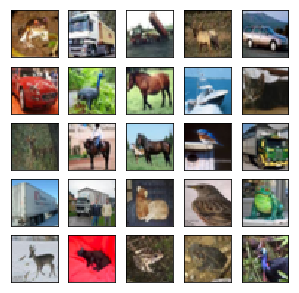

--------------------
Testing images : 10000 images.


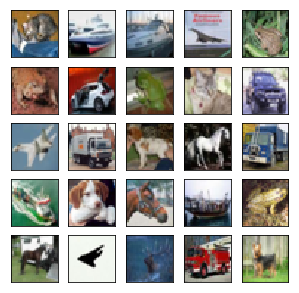

In [7]:
# Create a function to plot/visualize the images.

def plot_25images(images):
    
    # figure size
    fig = plt.figure(figsize=(5,5))
    
    # plot image grid
    for x in range(5):
        for y in range(5):
            ax = fig.add_subplot(5, 5, 5*y+x+1)
            plt.imshow(images[5*y+x])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

# Load the CIFAR-10 dataset through tf
# Note : could take a few minutes depending on machine...

(x_train, y_train), (x_test, y_test)= datasets.cifar10.load_data()

# Visualize CIFAR images

print('Training images : ' + str(x_train.shape[0]) + ' images.')
plot_25images(x_train[:25])

print(20 * '-')

print('Testing images : ' + str(x_test.shape[0]) + ' images.')
plot_25images(x_test[:25])


In [8]:
# one hot encode the target

y_train = utils.to_categorical(y_train, num_classes = 10)
y_test = utils.to_categorical(y_test, num_classes = 10)

# preprocessing with ImageDataGenerator (training data generator has additional augumentation steps, the test only has rescale)

train_data_gen = preprocessing_image.ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip=True)

test_data_gen = preprocessing_image.ImageDataGenerator(rescale = 1/255)

# create a data generator to feed the network

train_generator = train_data_gen.flow(x = x_train, y = y_train, batch_size = 32, shuffle = True) # 32 images at a time
test_generator = train_data_gen.flow(x = x_test, y = y_test, batch_size = 32, shuffle = True)

In [9]:
# Compile model (add loss, optimizer, etc)

def compile_squeeze(model):
    
    # loss - multi class (10) classification problem ~ crossentropy
    
    loss = losses.categorical_crossentropy
    
    # optimizer
    # paper used a lr of 0.04, but I am not sure which optimizer they used
    # I used ADAM optimizer with a lr = 0.001, which is typically a good 'starting point'
    
    optimizer = optimizers.Adam(lr=0.001)
                                          
    # metrics - top_k_categorical calculates the accuracy given the top 5 predictions of the model.
    
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    
    # compile model with loss, optimizer, and evaluation metrics
    
    model.compile(optimizer, loss, metric)
    
    return model

In [10]:
# compile the model

squeezeNet = SqueezeNet()
squeezeNet = compile_squeeze(squeezeNet)

In [ ]:
training = squeezeNet.fit_generator(
    train_generator,
    steps_per_epoch = 400,
    epochs = 100,
    validation_data = test_generator,
    validation_steps = 200)

Epoch 1/100


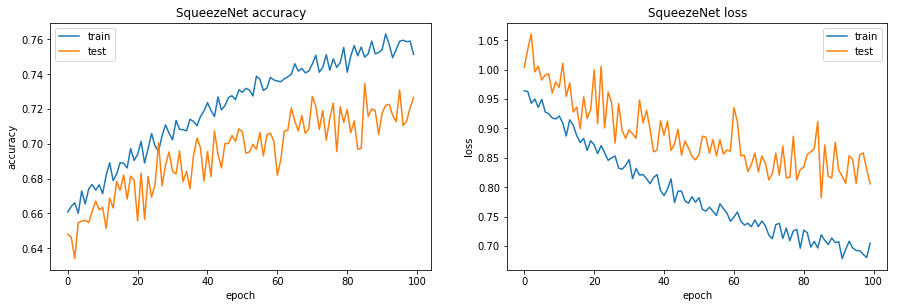

In [11]:
def plot_accuracy_and_loss(training):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(training.history['categorical_accuracy'])
    plt.plot(training.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()
    
plot_accuracy_and_loss(training)

In [9]:
# save model architecture
model_json = squeezeNet.to_json()
open('models/squeeze_net.json', 'w').write(model_json)

# save model's learned weights
squeezeNet.save_weights('models/squeeze_net.h5', overwrite=True)